# First we add the libraries we will use

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import scipy.stats as stats
from scipy.stats import spearmanr
import os
import glob
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# We define and filter data

In [2]:
df = pd.read_csv("/Users/emreserhatakkas/Downloads/project_data.csv")

In [3]:
df3 = pd.concat(map(pd.read_csv, glob.glob('/Users/emreserhatakkas/Downloads/emresakkas_churndata/*.csv')))

In [4]:
main_data = df3.filter(items = ['industry','churn_type'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97419 entries, 0 to 97418
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            97419 non-null  int64 
 1   created_at         97419 non-null  object
 2   account_type       97419 non-null  object
 3   status             97419 non-null  object
 4   first_upgrade      97419 non-null  object
 5   last_upgrade       97419 non-null  object
 6   cancel_date        97419 non-null  object
 7   activeness         45320 non-null  object
 8   total_paid_months  97419 non-null  int64 
 9   ever_paid          97419 non-null  int64 
 10  total_amount_paid  97419 non-null  int64 
 11  plan               29007 non-null  object
 12  churn_type         29007 non-null  object
 13  churn_date         29007 non-null  object
 14  currency           97419 non-null  object
dtypes: int64(4), object(11)
memory usage: 11.1+ MB


In [6]:
df.head()

,user_id,created_at,account_type,status,first_upgrade,last_upgrade,cancel_date,activeness,total_paid_months,ever_paid,total_amount_paid,plan,churn_type,churn_date,currency
0,4514312841,2020-04-14 08:54:10 UTC,PLATINUM,ACTIVE,2020-04-14 09:06:03 UTC,2021-04-25 17:29:17 UTC,2020-04-25 14:03:35 UTC,NaN,24,1,10079,NaN,NaN,NaN,USD
1,4545592751,2020-08-12 15:48:38 UTC,GOLD,ACTIVE,2015-09-24 19:19:48 UTC,2021-08-12 06:36:09 UTC,1970-01-01 00:00:00 UTC,very active,20,1,3726,SILVER,LONG-TERM,2020-04-26 16:32:56 UTC,USD
2,4560543341,2020-10-05 05:35:58 UTC,GOLD,ACTIVE,2020-10-05 05:38:37 UTC,2021-10-25 06:19:16 UTC,2021-10-25 06:10:02 UTC,NaN,18,1,3113,NaN,NaN,NaN,USD
3,4500768231,2020-01-30 10:23:54 UTC,GOLD,ACTIVE,2020-01-30 10:25:17 UTC,2022-04-11 09:40:43 UTC,2022-04-08 22:57:42 UTC,very active,27,1,3050,NaN,NaN,NaN,USD
4,4534521641,2020-07-01 13:44:06 UTC,FREE,ACTIVE,2016-05-06 11:06:07 UTC,2019-09-06 12:07:11 UTC,1970-01-01 00:00:00 UTC,NaN,41,1,3023,NaN,NaN,NaN,USD


# We convert date indicating variables from object to datetime

In [7]:
df[["created_at","first_upgrade","last_upgrade","cancel_date","churn_date"]] = df[["created_at","first_upgrade","last_upgrade","cancel_date","churn_date"]].apply(pd.to_datetime)

# We define paid-customers terms (short, mid, long)

In [8]:
a = df.loc[(df.total_paid_months > 0) & (df.total_paid_months <= 3)]
b = df.loc[(df.total_paid_months > 3) & (df.total_paid_months < 14)]
c = df.loc[(df.total_paid_months >= 14)]
d = df.loc[(df.total_paid_months < 1)]

In [9]:
a = a.assign(customer_term_type = 'short_term')
b = b.assign(customer_term_type = 'mid_term')
c = c.assign(customer_term_type = 'long_term')
d = d.assign(customer_term_type = 'free')

In [10]:
df = pd.concat([a,b,c,d])

# We get information about the latest version of data

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97419 entries, 740 to 97418
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user_id             97419 non-null  int64              
 1   created_at          97419 non-null  datetime64[ns, UTC]
 2   account_type        97419 non-null  object             
 3   status              97419 non-null  object             
 4   first_upgrade       97419 non-null  datetime64[ns, UTC]
 5   last_upgrade        97419 non-null  datetime64[ns, UTC]
 6   cancel_date         97419 non-null  datetime64[ns, UTC]
 7   activeness          45320 non-null  object             
 8   total_paid_months   97419 non-null  int64              
 9   ever_paid           97419 non-null  int64              
 10  total_amount_paid   97419 non-null  int64              
 11  plan                29007 non-null  object             
 12  churn_type          29007 non-

# We will calculate monthly and termly churn ratios, for this reason we must filter dates. Now we will filter data by month.

In [13]:
now = pd.Timestamp.now().to_period('m')
YearMonths = pd.period_range(now-31, freq='M', periods=31).strftime('%Y-%m').tolist()

In [14]:
YearMonths

['2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06',
 '2020-07',
 '2020-08',
 '2020-09',
 '2020-10',
 '2020-11',
 '2020-12',
 '2021-01',
 '2021-02',
 '2021-03',
 '2021-04',
 '2021-05',
 '2021-06',
 '2021-07',
 '2021-08',
 '2021-09',
 '2021-10',
 '2021-11',
 '2021-12',
 '2022-01',
 '2022-02',
 '2022-03',
 '2022-04',
 '2022-05',
 '2022-06',
 '2022-07']

# We define churn and plan rates functions. After defining we'll calculate churn and plan ratios

In [15]:
dict_stmcr = {}
for i, ym in enumerate(YearMonths[1:]):
    t2 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    u2 = t2[t2['churn_type'] == "SHORT-TERM"].shape[0]
    c2 = t2['churn_type'].shape[0]
    stmcr = u2/c2
    dict_stmcr[YearMonths[i]]= stmcr

In [16]:
dict_stmcr

{'2020-01': 0.972972972972973,
 '2020-02': 0.9703389830508474,
 '2020-03': 0.9269102990033222,
 '2020-04': 0.906392694063927,
 '2020-05': 0.8590604026845637,
 '2020-06': 0.8285256410256411,
 '2020-07': 0.7789017341040463,
 '2020-08': 0.7394843962008141,
 '2020-09': 0.7167701863354037,
 '2020-10': 0.7205387205387206,
 '2020-11': 0.6796116504854369,
 '2020-12': 0.5775147928994083,
 '2021-01': 0.5852760736196319,
 '2021-02': 0.6537313432835821,
 '2021-03': 0.6400359066427289,
 '2021-04': 0.6053484602917342,
 '2021-05': 0.6299275945293644,
 '2021-06': 0.5805604203152365,
 '2021-07': 0.5063492063492063,
 '2021-08': 0.5565142364106989,
 '2021-09': 0.5780757097791798,
 '2021-10': 0.5489766081871345,
 '2021-11': 0.5265454545454545,
 '2021-12': 0.4645669291338583,
 '2022-01': 0.4934839270199826,
 '2022-02': 0.5111441307578009,
 '2022-03': 0.5501373626373627,
 '2022-04': 0.4992987377279102,
 '2022-05': 0.39477726574500765,
 '2022-06': 0.3133971291866029}

In [17]:
dict_ltmcr = {}
for i, ym in enumerate(YearMonths[1:]):
    t3 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    u3 = t3[t3['churn_type'] == "LONG-TERM"].shape[0]
    c3 = t3['churn_type'].shape[0]
    ltmcr = u3/c3
    dict_ltmcr[YearMonths[i]]= ltmcr

In [18]:
dict_ltmcr

{'2020-01': 0.009009009009009009,
 '2020-02': 0.00423728813559322,
 '2020-03': 0.006644518272425249,
 '2020-04': 0.0045662100456621,
 '2020-05': 0.003355704697986577,
 '2020-06': 0.00641025641025641,
 '2020-07': 0.001445086705202312,
 '2020-08': 0.0013568521031207597,
 '2020-09': 0.007453416149068323,
 '2020-10': 0.003367003367003367,
 '2020-11': 0.007551240560949299,
 '2020-12': 0.016568047337278107,
 '2021-01': 0.018404907975460124,
 '2021-02': 0.023880597014925373,
 '2021-03': 0.02423698384201077,
 '2021-04': 0.03727714748784441,
 '2021-05': 0.04102976669348351,
 '2021-06': 0.05166374781085814,
 '2021-07': 0.08095238095238096,
 '2021-08': 0.0724762726488352,
 '2021-09': 0.08123028391167192,
 '2021-10': 0.09941520467836257,
 '2021-11': 0.10909090909090909,
 '2021-12': 0.12913385826771653,
 '2022-01': 0.13205907906168549,
 '2022-02': 0.13150074294205052,
 '2022-03': 0.11881868131868131,
 '2022-04': 0.1402524544179523,
 '2022-05': 0.17204301075268819,
 '2022-06': 0.2117224880382775}

In [19]:
dict_mtmcr = {}
for i, ym in enumerate(YearMonths[1:]):
    t4 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    u4 = t4[t4['churn_type'] == "MID-TERM"].shape[0]
    c4 = t4['churn_type'].shape[0]
    mtmcr = u4/c4
    dict_mtmcr[YearMonths[i]]= mtmcr

In [20]:
dict_mtmcr

{'2020-01': 0.018018018018018018,
 '2020-02': 0.025423728813559324,
 '2020-03': 0.0664451827242525,
 '2020-04': 0.08904109589041095,
 '2020-05': 0.13758389261744966,
 '2020-06': 0.16506410256410256,
 '2020-07': 0.21965317919075145,
 '2020-08': 0.2591587516960651,
 '2020-09': 0.27577639751552796,
 '2020-10': 0.2760942760942761,
 '2020-11': 0.31283710895361383,
 '2020-12': 0.4059171597633136,
 '2021-01': 0.39631901840490796,
 '2021-02': 0.32238805970149254,
 '2021-03': 0.3357271095152603,
 '2021-04': 0.3573743922204214,
 '2021-05': 0.32904263877715206,
 '2021-06': 0.36777583187390545,
 '2021-07': 0.4126984126984127,
 '2021-08': 0.3710094909404659,
 '2021-09': 0.34069400630914826,
 '2021-10': 0.3516081871345029,
 '2021-11': 0.3643636363636364,
 '2021-12': 0.4062992125984252,
 '2022-01': 0.37445699391833187,
 '2022-02': 0.3573551263001486,
 '2022-03': 0.33104395604395603,
 '2022-04': 0.36044880785413747,
 '2022-05': 0.43317972350230416,
 '2022-06': 0.4748803827751196}

In [22]:
stmcr_date = list(dict_stmcr.keys())
stmcr_values = list(dict_stmcr.values())
ltmcr_date = list(dict_ltmcr.keys())
ltmcr_values = list(dict_ltmcr.values())
mtmcr_date = list(dict_mtmcr.keys())
mtmcr_values = list(dict_mtmcr.values())

In [23]:
all_churnpercentages = pd.DataFrame(list(zip(stmcr_date, stmcr_values,mtmcr_values,ltmcr_values)),
                           columns =['Date', 'Short-Term Churn Ratio(%)','Mid-Term Churn Ratio(%)','Long-Term Churn Ratio(%)'])

In [24]:
all_churnpercentages

,Date,Short-Term Churn Ratio(%),Mid-Term Churn Ratio(%),Long-Term Churn Ratio(%)
0,2020-01,0.972973,0.018018,0.009009
1,2020-02,0.970339,0.025424,0.004237
2,2020-03,0.926910,0.066445,0.006645
3,2020-04,0.906393,0.089041,0.004566
4,2020-05,0.859060,0.137584,0.003356
5,2020-06,0.828526,0.165064,0.006410
6,2020-07,0.778902,0.219653,0.001445
7,2020-08,0.739484,0.259159,0.001357
8,2020-09,0.716770,0.275776,0.007453
9,2020-10,0.720539,0.276094,0.003367


In [25]:
dict_stcr = {}
for i, ym in enumerate(YearMonths[1:]):
    j1 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    j2 = j1.loc[(j1['churn_type'] == "SHORT-TERM")].shape[0]
    j3 = df.loc[(df.churn_date.isna()) | (df.churn_date.dt.strftime('%Y-%m') >= ym)].shape[0]
    stcr = j2/j3*100
    dict_stcr[YearMonths[i]]= stcr

In [26]:
dict_stcr

{'2020-01': 0.11090003593982646,
 '2020-02': 0.23541748051894648,
 '2020-03': 0.28751623075496197,
 '2020-04': 0.41039106029750766,
 '2020-05': 0.5316773798274125,
 '2020-06': 0.5402129504822211,
 '2020-07': 0.566897001440907,
 '2020-08': 0.5774100246856029,
 '2020-09': 0.616123865456487,
 '2020-10': 0.6914750390435672,
 '2020-11': 0.6851251712812928,
 '2020-12': 0.5361046722401046,
 '2021-01': 0.5289303852209976,
 '2021-02': 0.735170700594179,
 '2021-03': 0.8069079468549829,
 '2021-04': 0.8561800843572345,
 '2021-05': 0.9103169251517196,
 '2021-06': 0.7821070885090421,
 '2021-07': 0.7628932547322101,
 '2021-08': 0.7830615887044883,
 '2021-09': 0.9025982021918483,
 '2021-10': 0.9394310875384653,
 '2021-11': 0.9214243897472446,
 '2021-12': 0.7642586043860672,
 '2022-01': 0.7480672733738097,
 '2022-02': 0.920056701168793,
 '2022-03': 1.090805098594618,
 '2022-04': 0.9892186284316994,
 '2022-05': 0.7285613040396882,
 '2022-06': 0.37835027726432535}

In [27]:
dict_mtcr = {}
for i, ym in enumerate(YearMonths[1:]):
    j4 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    j5 = j4.loc[(j4['churn_type'] == "MID-TERM")].shape[0]
    j6 = df.loc[(df.churn_date.isna()) | (df.churn_date.dt.strftime('%Y-%m') >= ym)].shape[0]
    mtcr = j5/j6*100
    dict_mtcr[YearMonths[i]]= mtcr

In [28]:
dict_mtcr

{'2020-01': 0.0020537043692560454,
 '2020-02': 0.006168143594382877,
 '2020-03': 0.020610482491395122,
 '2020-04': 0.04031549458842015,
 '2020-05': 0.08515145536298403,
 '2020-06': 0.10762463036686415,
 '2020-07': 0.1598670579202558,
 '2020-08': 0.20235837562376174,
 '2020-09': 0.23705285638013882,
 '2020-10': 0.26495772524099304,
 '2020-11': 0.3153750788437697,
 '2020-12': 0.3768112757753194,
 '2021-01': 0.35816460047459586,
 '2021-02': 0.3625499345395951,
 '2021-03': 0.42325886693374987,
 '2021-04': 0.5054557124518614,
 '2021-05': 0.47550398772292884,
 '2021-06': 0.4954524542591216,
 '2021-07': 0.621793875330328,
 '2021-08': 0.5220410591363255,
 '2021-09': 0.531954192833395,
 '2021-10': 0.6016862225113208,
 '2021-11': 0.6376154962201237,
 '2021-12': 0.6684024404461197,
 '2022-01': 0.5676355542678029,
 '2022-02': 0.643237315788066,
 '2022-03': 0.6563895849221048,
 '2022-04': 0.7141269311992887,
 '2022-05': 0.7994330262225372,
 '2022-06': 0.5733017560073936}

In [29]:
dict_ltcr = {}
for i, ym in enumerate(YearMonths[1:]):
    j7 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    j8 = j7.loc[(j7['churn_type'] == "LONG-TERM")].shape[0]
    j9 = df.loc[(df.churn_date.isna()) | (df.churn_date.dt.strftime('%Y-%m') >= ym)].shape[0]
    ltcr = j8/j9*100
    dict_ltcr[YearMonths[i]]= ltcr

In [30]:
dict_ltcr

{'2020-01': 0.0010268521846280227,
 '2020-02': 0.0010280239323971463,
 '2020-03': 0.0020610482491395126,
 '2020-04': 0.002067461260944623,
 '2020-05': 0.00207686476495083,
 '2020-06': 0.00417959729580055,
 '2020-07': 0.0010517569600016828,
 '2020-08': 0.0010594679352029413,
 '2020-09': 0.0064068339562199685,
 '2020-10': 0.0032311917712316224,
 '2020-11': 0.007612501903125475,
 '2020-12': 0.015380052072462016,
 '2021-01': 0.016633030981792373,
 '2021-02': 0.02685555070663668,
 '2021-03': 0.030556121409655735,
 '2021-04': 0.0527232715936182,
 '2021-05': 0.05929267328574418,
 '2021-06': 0.06959927333640041,
 '2021-07': 0.12196726016094894,
 '2021-08': 0.10198011387779382,
 '2021-09': 0.12683167097648074,
 '2021-10': 0.17012333942108027,
 '2021-11': 0.19090284317967776,
 '2021-12': 0.21243798494799157,
 '2022-01': 0.20018701681834344,
 '2022-02': 0.23670063387627374,
 '2022-03': 0.235592112430548,
 '2022-04': 0.2778704012448594,
 '2022-05': 0.3175053153791637,
 '2022-06': 0.255603049907578

In [31]:
dict_totalchurn = {}
for i, ym in enumerate(YearMonths[1:]):
    c5 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)].shape[0]
    y5 = df.loc[(df.customer_term_type != 'free')]
    t5 = y5.loc[(y5.churn_date.isna()) | (y5.churn_date.dt.strftime('%Y-%m') >= ym)].shape[0]
    total_churn = c5/t5*100
    dict_totalchurn[YearMonths[i]]= total_churn

In [32]:
dict_totalchurn

{'2020-01': 0.13298987599592643,
 '2020-02': 0.28308563340410475,
 '2020-03': 0.36202251515443085,
 '2020-04': 0.5285514311917748,
 '2020-05': 0.7228448066753991,
 '2020-06': 0.7621746405931282,
 '2020-07': 0.8515141447327944,
 '2020-08': 0.9143920595533499,
 '2020-09': 1.0076859524822872,
 '2020-10': 1.126365291262136,
 '2020-11': 1.1848916725250846,
 '2020-12': 1.0927336445576692,
 '2021-01': 1.0651367034345758,
 '2021-02': 1.3272407918543072,
 '2021-03': 1.490580175551274,
 '2021-04': 1.6752192446580327,
 '2021-05': 1.715665976535542,
 '2021-06': 1.603257054611821,
 '2021-07': 1.7969451931716083,
 '2021-08': 1.6821236266527335,
 '2021-09': 1.870868744098206,
 '2021-10': 2.0560916223284336,
 '2021-11': 2.1090574430554487,
 '2021-12': 1.9893172099434535,
 '2022-01': 1.8385113010142962,
 '2022-02': 2.189472314399115,
 '2022-03': 2.420252996226666,
 '2022-04': 2.4256238411947812,
 '2022-05': 2.258887211783688,
 '2022-06': 1.475467702082598}

In [33]:
stcr_date = list(dict_stcr.keys())
stcr_values = list(dict_stcr.values())
ltcr_values = list(dict_ltcr.values())
mtcr_values = list(dict_mtcr.values())
totalchurn_values = list(dict_totalchurn.values())

In [34]:
all_churnrates = pd.DataFrame(list(zip(stcr_date, stcr_values,mtcr_values,ltcr_values,totalchurn_values)),
                           columns =['Date', 'Short-Term Churn Ratio(%)','Mid-Term Churn Ratio(%)','Long-Term Churn Ratio(%)','Total Churn Ratio(%)'])

In [35]:
all_churnrates

,Date,Short-Term Churn Ratio(%),Mid-Term Churn Ratio(%),Long-Term Churn Ratio(%),Total Churn Ratio(%)
0,2020-01,0.110900,0.002054,0.001027,0.132990
1,2020-02,0.235417,0.006168,0.001028,0.283086
2,2020-03,0.287516,0.020610,0.002061,0.362023
3,2020-04,0.410391,0.040315,0.002067,0.528551
4,2020-05,0.531677,0.085151,0.002077,0.722845
5,2020-06,0.540213,0.107625,0.004180,0.762175
6,2020-07,0.566897,0.159867,0.001052,0.851514
7,2020-08,0.577410,0.202358,0.001059,0.914392
8,2020-09,0.616124,0.237053,0.006407,1.007686
9,2020-10,0.691475,0.264958,0.003231,1.126365


In [36]:
dict_goldplan = {}
for i, ym in enumerate(YearMonths[1:]):
    z4 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    x4 = z4[z4['plan'] == "GOLD"].shape[0]
    v4 = z4['plan'].shape[0]
    gold_plan = x4/v4
    dict_goldplan[YearMonths[i]]= gold_plan

In [37]:
dict_silverplan = {}
for i, ym in enumerate(YearMonths[1:]):
    z5 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    x5 = z5[z5['plan'] == "SILVER"].shape[0]
    v5 = z5['plan'].shape[0]
    silver_plan = x5/v5
    dict_silverplan[YearMonths[i]]= silver_plan

In [38]:
dict_bronzeplan = {}
for i, ym in enumerate(YearMonths[1:]):
    z6 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    x6 = z6[z6['plan'] == "BRONZE"].shape[0]
    v6 = z6['plan'].shape[0]
    bronze_plan = x6/v6
    dict_bronzeplan[YearMonths[i]]= bronze_plan

In [39]:
dict_professionalplan = {}
for i, ym in enumerate(YearMonths[1:]):
    z7 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    x7 = z6[z6['plan'] == "PROFESSIONAL"].shape[0]
    v7 = z6['plan'].shape[0]
    professional_plan = x7/v7
    dict_professionalplan[YearMonths[i]]= professional_plan

In [40]:
goldplan_date = list(dict_goldplan.keys())
goldplan_values = list(dict_goldplan.values())
silverplan_values = list(dict_silverplan.values())
bronzeplan_values = list(dict_bronzeplan.values())
professional_values = list(dict_professionalplan.values())

In [41]:
all_plans = pd.DataFrame(list(zip(goldplan_date, goldplan_values,silverplan_values,bronzeplan_values,professional_values)),
                           columns =['Date', 'Gold Plan Ratio(%)','Silver Plan Ratio(%)','Bronze Plan Ratio(%)', 'Professional Plan Ratio(%)'])

In [42]:
all_plans

,Date,Gold Plan Ratio(%),Silver Plan Ratio(%),Bronze Plan Ratio(%),Professional Plan Ratio(%)
0,2020-01,0.000000,0.153153,0.828829,0.0
1,2020-02,0.004237,0.177966,0.817797,0.0
2,2020-03,0.023256,0.215947,0.757475,0.0
3,2020-04,0.009132,0.226027,0.755708,0.0
4,2020-05,0.028523,0.234899,0.736577,0.0
5,2020-06,0.017628,0.241987,0.735577,0.0
6,2020-07,0.014451,0.239884,0.745665,0.0
7,2020-08,0.010855,0.255088,0.728630,0.0
8,2020-09,0.017391,0.233540,0.741615,0.0
9,2020-10,0.017957,0.251403,0.723906,0.0


# Now we have a dataset with churn and plan ratios. We begin to visualize this datasets

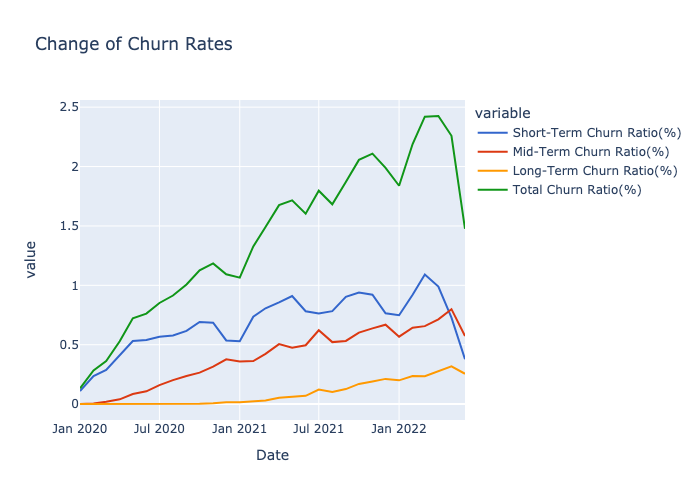

Short-Term Customer: 3 or less than 3 months paid customer
Mid-Term Customer: Between 3-14 months paid customer
Long-Term Customer: 14 or more than 14 months paid customer


In [43]:
fig = px.line(all_churnrates, x='Date', y=all_churnrates.columns[1:5], title="Change of Churn Rates",  color_discrete_sequence=px.colors.qualitative.G10)
fig.show("png")
print("Short-Term Customer: 3 or less than 3 months paid customer")
print("Mid-Term Customer: Between 3-14 months paid customer")
print("Long-Term Customer: 14 or more than 14 months paid customer")

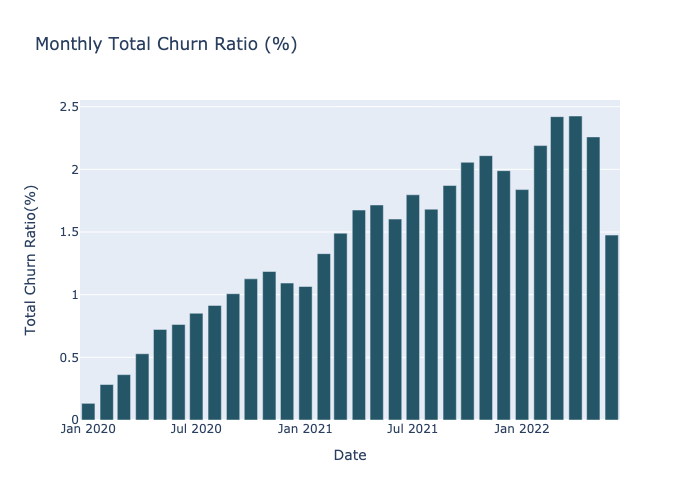

In [44]:
fig = px.bar(all_churnrates, x="Date", y="Total Churn Ratio(%)", title="Monthly Total Churn Ratio (%)", color_discrete_sequence=px.colors.carto.Aggrnyl)
fig.show("png")

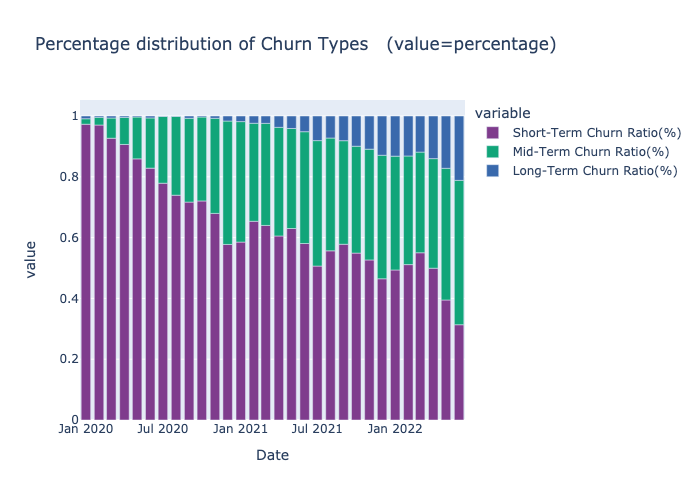

Short-Term Customer: 3 or less than 3 months paid customer
Mid-Term Customer: Between 3-14 months paid customer
Long-Term Customer: 14 or more than 14 months paid customer


In [45]:
fig = px.bar(all_churnpercentages , x="Date", y=['Short-Term Churn Ratio(%)', 'Mid-Term Churn Ratio(%)', 'Long-Term Churn Ratio(%)'],title="Percentage distribution of Churn Types \n (value=percentage)",color_discrete_sequence=px.colors.qualitative.Bold)
fig.show("png")
print("Short-Term Customer: 3 or less than 3 months paid customer")
print("Mid-Term Customer: Between 3-14 months paid customer")
print("Long-Term Customer: 14 or more than 14 months paid customer")

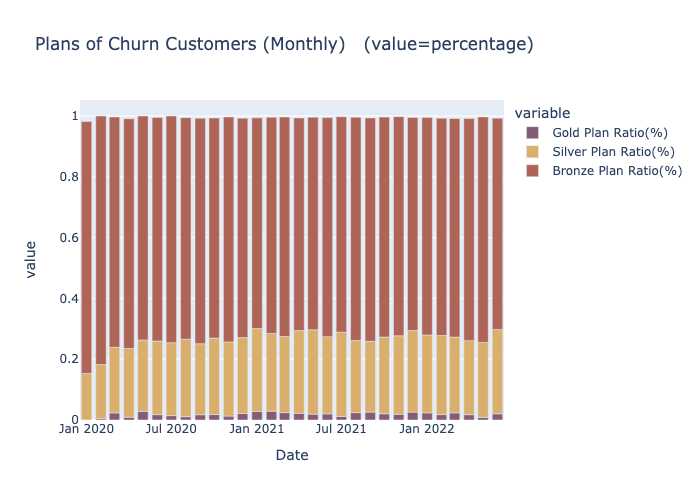

(Storage, Guest and Professional plans are excluded)


In [46]:
fig = px.bar(all_plans , x="Date", y=['Gold Plan Ratio(%)', 'Silver Plan Ratio(%)', 'Bronze Plan Ratio(%)'],title="Plans of Churn Customers (Monthly) \n (value=percentage)",color_discrete_sequence=px.colors.qualitative.Antique)
fig.show("png")
print("(Storage, Guest and Professional plans are excluded)")

In [47]:
g = main_data.loc[(main_data.churn_type == "LONG-TERM")]
t = g.industry.value_counts().head(15)
u = ('construction','arts & design','non-profit organizations','education','health care and social assistance','e-commerce & retail trade','event organization','advertising, marketing & research','food & beverages','sports & activities','finance','transportation','information technology','beauty & personal care','public administration')                

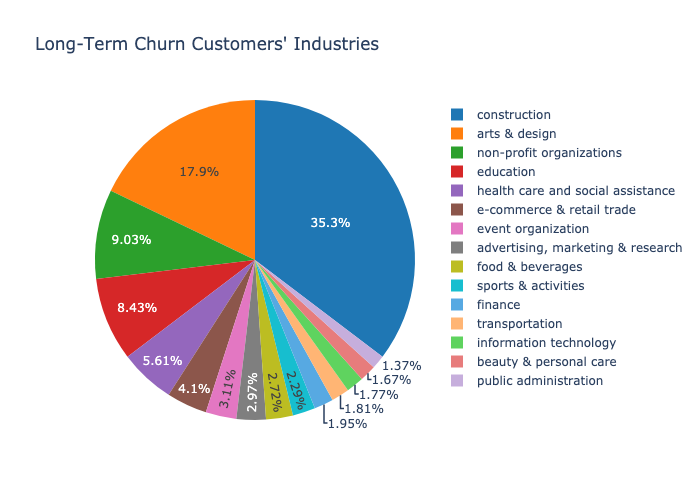

(Only users with industry knowledge in the system are included in this chart.)


In [48]:
fig = px.pie(main_data, values = t,names = u,title = "Long-Term Churn Customers' Industries",  color_discrete_sequence=px.colors.qualitative.D3)
fig.show("png")
print("(Only users with industry knowledge in the system are included in this chart.)")

In [49]:
k = main_data.loc[(main_data.churn_type == "MID-TERM")]
y = k.industry.value_counts().head(15)
i = ('construction','non-profit organizations','arts & design','education','health care and social assistance','e-commerce & retail trade','sports & activities','event organization','food & beverages','finance','advertising, marketing & research','information technology','public administration','beauty & personal care','transportation')

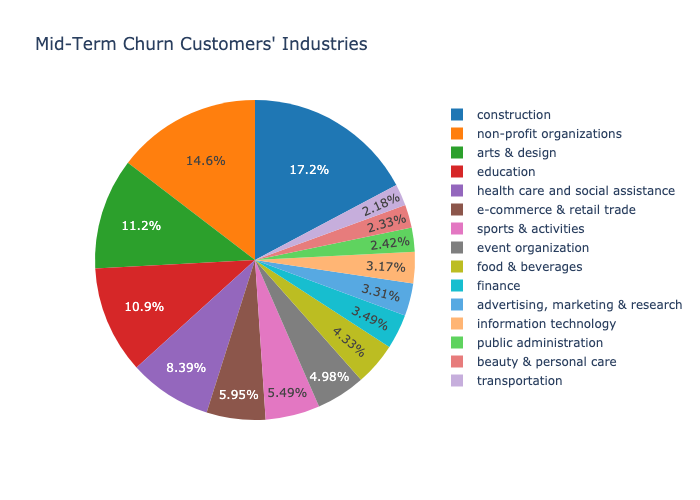

(Only users with industry knowledge in the system are included in this chart.)


In [50]:
fig = px.pie(main_data, values = y, names = i, title = "Mid-Term Churn Customers' Industries",  color_discrete_sequence=px.colors.qualitative.D3)
fig.show("png")
print("(Only users with industry knowledge in the system are included in this chart.)")

In [51]:
h = main_data.loc[(main_data.churn_type == "SHORT-TERM")]
p = h.industry.value_counts().head(15)
r = ('non-profit organizations','education','health care and social assistance','e-commerce & retail trade','sports & activities','event organization','arts & design','food & beverages','finance','information technology','advertising, marketing & research','public administration','real estate & leasing','beauty & personal care','transportation')

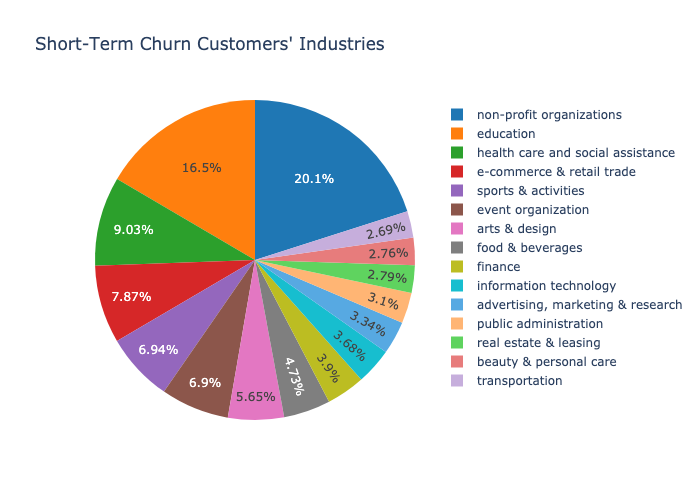

(Only users with industry knowledge in the system are included in this chart.)


In [52]:
fig = px.pie(main_data, values = p,names = r,title = "Short-Term Churn Customers' Industries",  color_discrete_sequence=px.colors.qualitative.D3)
fig.show("png")
print("(Only users with industry knowledge in the system are included in this chart.)")

# Now that Churn analysis is finished, we can move on to Life Time Span and CLTV analysis.

In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life-time value (LTV) is a prognostication of the net profit contributed to the whole future relationship with a customer.

# We define CLTV function and calculate monthly CLTV

In [53]:
dict_cltv = {}
for i, ym in enumerate(YearMonths[1:]):
    t1 = df.loc[(df.churn_date.dt.strftime('%Y-%m') == ym)]
    u1 = t1.user_id.shape[0]
    c1 = t1.total_amount_paid.sum()
    cltv = c1/u1
    dict_cltv[YearMonths[i]]= cltv

In [54]:
cltv_list_date = list(dict_cltv.keys())
cltv_list_values = list(dict_cltv.values())

In [55]:
CLTV = pd.DataFrame(list(zip(cltv_list_date, cltv_list_values)),
                           columns =['Date', 'CLTV'])

In [56]:
CLTV

,Date,CLTV
0,2020-01,94.009009
1,2020-02,123.042373
2,2020-03,143.897010
3,2020-04,112.461187
4,2020-05,135.865772
5,2020-06,136.333333
6,2020-07,146.631503
7,2020-08,142.527815
8,2020-09,151.780124
9,2020-10,144.919192


# We define Customers Life Time Span function and calculate monthly Life Time Span

In [57]:
df1 = pd.read_csv('/Users/emreserhatakkas/Downloads/bq-results-20220718-133529-1658151349029.csv')

In [58]:
df1.head()

,user_id,action,period,date_time
0,4496347601,NaN,NaN,NaN
1,4496347621,NaN,NaN,NaN
2,4496347631,NaN,NaN,NaN
3,4496347641,NaN,NaN,NaN
4,4496347651,NaN,NaN,NaN


In [59]:
df1 = df1.loc[(df1.date_time >= '2018-01')]

In [60]:
def period_calculater(row):
    if row['action'] == 'payment':
        multiplier = 1
    elif row['action'] == 'refund':
        multiplier = -1

    if row['period'] == '1 MONTH':
        return 1*multiplier
    elif row['period'] == '1 YEAR':
        return 12*multiplier
    elif row['period'] == '2 YEARS':
        return 24*multiplier
    else:
        return 0

In [61]:
df1['number_of_months'] = df1.apply(lambda row: period_calculater(row), axis = 1)

In [62]:
df1 = df1.sort_values(['user_id','date_time']).reset_index().drop(columns=['index'], axis = 1)
df1.head()

,user_id,action,period,date_time,number_of_months
0,4496352601,payment,1 YEAR,2020-01-07 20:15:13 UTC,12
1,4496352601,payment,1 YEAR,2021-01-14 21:17:22 UTC,12
2,4496352601,refund,1 YEAR,2021-01-15 04:11:04 UTC,-12
3,4496353001,payment,1 YEAR,2021-03-02 16:08:47 UTC,12
4,4496353001,payment,1 YEAR,2022-03-02 05:11:45 UTC,12


In [63]:
temp = df1.iloc[0]

for i, row in df1.iterrows():
    if row['period'] != '1 MONTH' and row['action'] == 'refund':
        if row['user_id'] == temp['user_id']:
            if pd.period_range(row['date_time'],freq='M',periods=1).strftime('%Y-%m').tolist()[0] != pd.period_range(temp['date_time'],freq='M',periods=1).strftime('%Y-%m').tolist()[0]:
                monthEnds = pd.period_range(row['date_time'],freq='M',periods=1) - pd.period_range(temp['date_time'],freq='M',periods=1)
                if row['period'] == '1 YEAR':
                    if str(monthEnds[0])[1] == 'M':
                        df1.at[i,'number_of_months'] = -11
                    else:
                        df1.at[i,'number_of_months'] = -1 * (12 - int(str(monthEnds[0]).split('<')[1].split(' * ')[0]))
                elif row['period'] == '2 YEARS':
                    if str(monthEnds[0])[1] == 'M':
                        df1.at[i,'number_of_months'] = -23
                    else:
                        df1.at[i,'number_of_months'] = -1 * (24 - int(str(monthEnds[0]).split('<')[1].split(' * ')[0]))
    temp = row

In [64]:
df1.loc[(df1.user_id == 4496487181)].sort_values('date_time', ascending=True)

,user_id,action,period,date_time,number_of_months
452,4496487181,payment,1 YEAR,2020-11-27 02:58:57 UTC,12
453,4496487181,payment,1 YEAR,2021-11-27 04:00:29 UTC,12
454,4496487181,refund,1 YEAR,2021-12-02 02:28:56 UTC,-11


In [65]:
dict_LifeTimeSpans = {}
for i, ym in enumerate(YearMonths[1:]):
    df1_temp = df1.loc[df1.date_time<ym]
    ever_paid_users = df1_temp.loc[(df1_temp.action == 'payment')].user_id.unique()
    df1_temp = df1_temp.loc[(df1_temp.user_id.isin(ever_paid_users))]
    df1_temp.sort_values('user_id', ascending=True, inplace=True)
    df1_LifeTimeSpan = df1_temp.groupby('user_id').sum()['number_of_months']
    dict_LifeTimeSpans[YearMonths[i]] = df1_LifeTimeSpan.mean()

In [66]:
dict_LifeTimeSpans

{'2020-01': 6.030754892823858,
 '2020-02': 6.096017699115044,
 '2020-03': 6.095616508587542,
 '2020-04': 5.9240037071362375,
 '2020-05': 6.071758017805427,
 '2020-06': 6.12910569105691,
 '2020-07': 6.240744420160276,
 '2020-08': 6.649751461189709,
 '2020-09': 6.683614744351962,
 '2020-10': 6.701625743735859,
 '2020-11': 6.972304832713754,
 '2020-12': 7.326794080965382,
 '2021-01': 7.572701560171527,
 '2021-02': 7.6370045520150995,
 '2021-03': 7.704200582855995,
 '2021-04': 7.82516889957632,
 '2021-05': 8.034990280477645,
 '2021-06': 8.239752125782127,
 '2021-07': 8.412565524003469,
 '2021-08': 8.776029290102269,
 '2021-09': 8.845769828412735,
 '2021-10': 8.914983099425225,
 '2021-11': 9.183660637255619,
 '2021-12': 9.572954380883418,
 '2022-01': 9.813004490209762,
 '2022-02': 9.926571619458207,
 '2022-03': 10.038568054573139,
 '2022-04': 10.234904553323496,
 '2022-05': 10.503758883074743,
 '2022-06': 10.8455757820474}

In [67]:
new_list_dates = list(dict_LifeTimeSpans.keys())
new_list_LifeTimeSpans = list(dict_LifeTimeSpans.values())

In [68]:
LifeTimeSpans = pd.DataFrame(list(zip(new_list_dates, new_list_LifeTimeSpans)),
                           columns =['Date', 'Life Time Span'])

In [69]:
LifeTimeSpans

,Date,Life Time Span
0,2020-01,6.030755
1,2020-02,6.096018
2,2020-03,6.095617
3,2020-04,5.924004
4,2020-05,6.071758
5,2020-06,6.129106
6,2020-07,6.240744
7,2020-08,6.649751
8,2020-09,6.683615
9,2020-10,6.701626


# Now we have a dataset with Life Time Spans and CLTVs. We begin to visualize this datasets

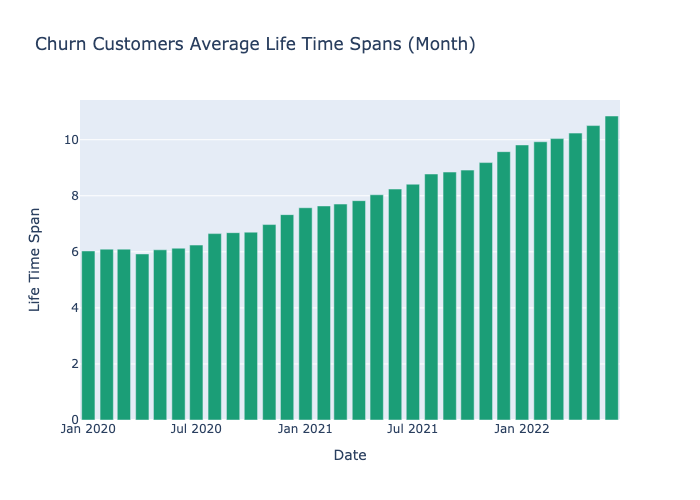

In [70]:
fig = px.bar(LifeTimeSpans, x="Date", y="Life Time Span", title="Churn Customers Average Life Time Spans (Month)",color_discrete_sequence=px.colors.qualitative.Dark2)
fig.show("png")

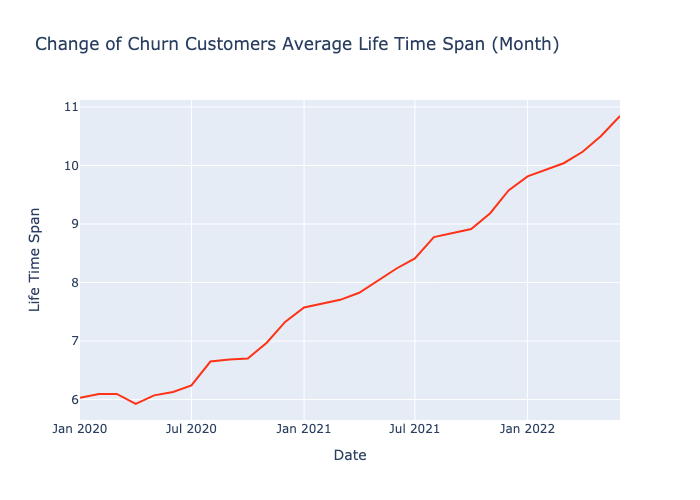

In [71]:
fig = px.line(LifeTimeSpans, x='Date', y="Life Time Span", title="Change of Churn Customers Average Life Time Span (Month)",  color_discrete_sequence=px.colors.qualitative.Light24)
fig.show("png")

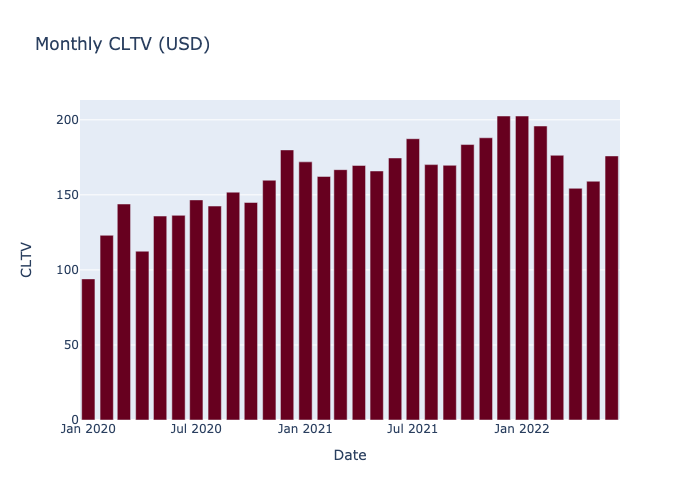

In [72]:
fig = px.bar(CLTV, x="Date", y="CLTV", title="Monthly CLTV (USD)",color_discrete_sequence=px.colors.colorbrewer.RdGy)
fig.show("png")

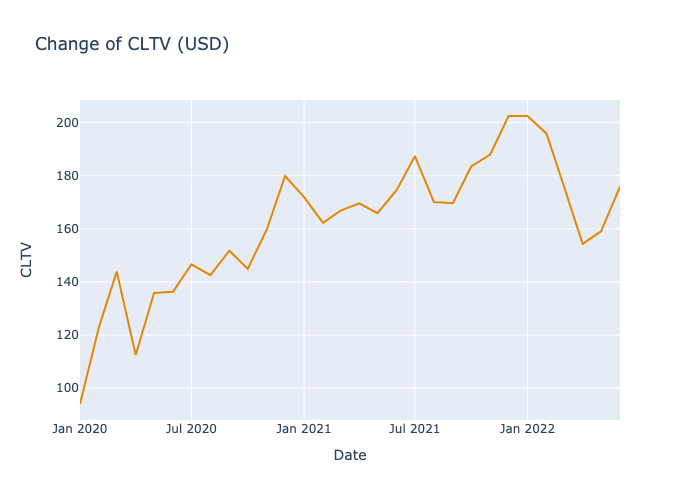

In [73]:
fig = px.line(CLTV, x='Date', y="CLTV", title="Change of CLTV (USD)",  color_discrete_sequence=px.colors.qualitative.Vivid)
fig.show("png")

In [75]:
All_Data = pd.DataFrame(list(zip(stcr_date,stcr_values,mtcr_values,ltcr_values,totalchurn_values, cltv_list_values ,new_list_LifeTimeSpans)),
                           columns =['Date', 'Short-Term Churn Ratio', 'Mid-Term Churn Ratio','Long-Term Churn Ratio','Total Churn Ratio','CLTV','Life Time Span'])

In [76]:
All_Data

,Date,Short-Term Churn Ratio,Mid-Term Churn Ratio,Long-Term Churn Ratio,Total Churn Ratio,CLTV,Life Time Span
0,2020-01,0.110900,0.002054,0.001027,0.132990,94.009009,6.030755
1,2020-02,0.235417,0.006168,0.001028,0.283086,123.042373,6.096018
2,2020-03,0.287516,0.020610,0.002061,0.362023,143.897010,6.095617
3,2020-04,0.410391,0.040315,0.002067,0.528551,112.461187,5.924004
4,2020-05,0.531677,0.085151,0.002077,0.722845,135.865772,6.071758
5,2020-06,0.540213,0.107625,0.004180,0.762175,136.333333,6.129106
6,2020-07,0.566897,0.159867,0.001052,0.851514,146.631503,6.240744
7,2020-08,0.577410,0.202358,0.001059,0.914392,142.527815,6.649751
8,2020-09,0.616124,0.237053,0.006407,1.007686,151.780124,6.683615
9,2020-10,0.691475,0.264958,0.003231,1.126365,144.919192,6.701626


# Let's move on to EDA (Exploratory Data Analysis)

In statistics, exploratory data analysis is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

In [77]:
all_churnrates.describe().T

,count,mean,std,min,25%,50%,75%,max
Short-Term Churn Ratio(%),30.0,0.677920,0.234457,0.110900,0.537132,0.731866,0.843862,1.090805
Mid-Term Churn Ratio(%),30.0,0.399212,0.237961,0.002054,0.211032,0.449381,0.594590,0.799433
Long-Term Churn Ratio(%),30.0,0.091685,0.103075,0.001027,0.003468,0.041640,0.185708,0.317505
Total Churn Ratio(%),30.0,1.398632,0.648461,0.132990,0.937716,1.483024,1.862779,2.425624


In [78]:
CLTV.describe().T

,count,mean,std,min,25%,50%,75%,max
CLTV,30.0,161.584208,25.431467,94.009009,145.34727,166.338192,176.246824,202.526772


In [79]:
LifeTimeSpans.describe().T

,count,mean,std,min,25%,50%,75%,max
Life Time Span,30.0,7.966809,1.550057,5.924004,6.658217,7.764685,9.116491,10.845576


# Outlier Analysis with Boxplot

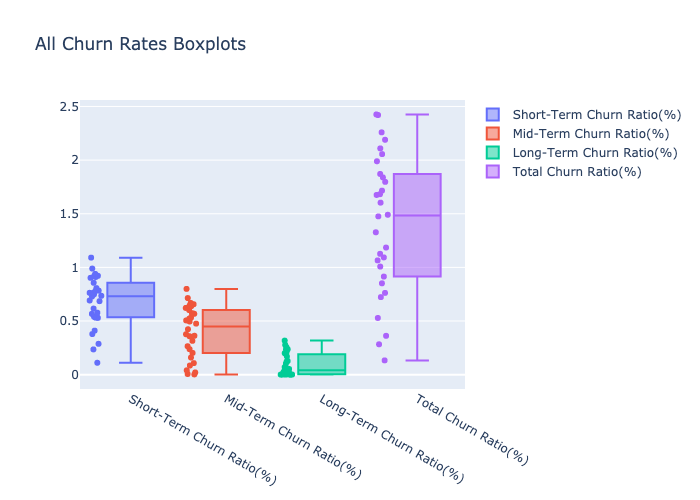

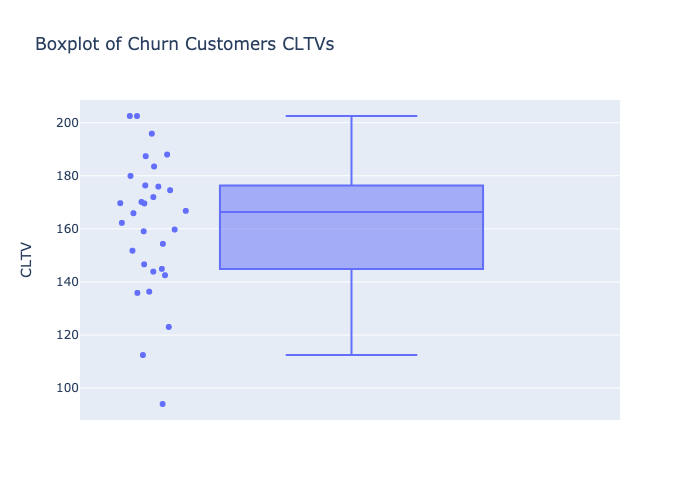

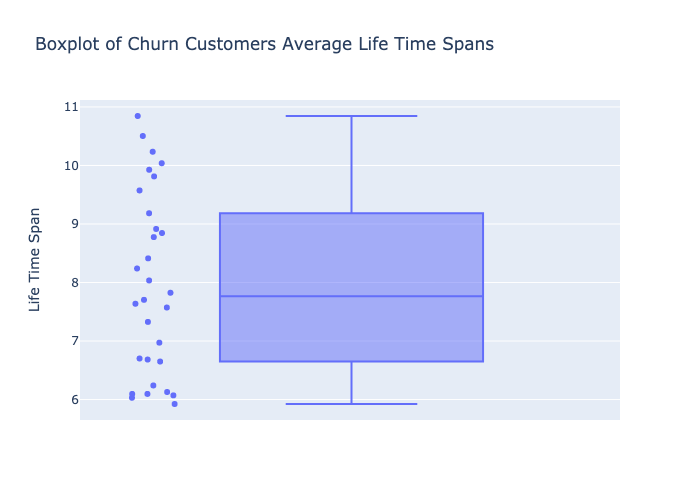

In [80]:
y0 = all_churnrates['Short-Term Churn Ratio(%)']
y1 = all_churnrates['Mid-Term Churn Ratio(%)']
y2 = all_churnrates['Long-Term Churn Ratio(%)']
y3 = all_churnrates['Total Churn Ratio(%)']
fig3 = px.box(CLTV, y="CLTV", points = "all", title = "Boxplot of Churn Customers CLTVs")
fig4 = px.box(LifeTimeSpans, y="Life Time Span", points = "all", title = "Boxplot of Churn Customers Average Life Time Spans")
fig = go.Figure()
fig.add_trace(go.Box(y=y0, name="Short-Term Churn Ratio(%)", boxpoints = 'all'))
fig.add_trace(go.Box(y=y1, name="Mid-Term Churn Ratio(%)", boxpoints = 'all'))
fig.add_trace(go.Box(y=y2, name="Long-Term Churn Ratio(%)", boxpoints = 'all'))
fig.add_trace(go.Box(y=y3, name="Total Churn Ratio(%)", boxpoints = 'all'))
fig.update_layout(title_text="All Churn Rates Boxplots")
fig.show("png")
fig3.show("png")
fig4.show("png")


We have not an outlier at data. This shows that there is no anomaly in our calculations.

# Distribution Analysis

It is very important for us to know the distribution of our data in order to further refine our analysis.

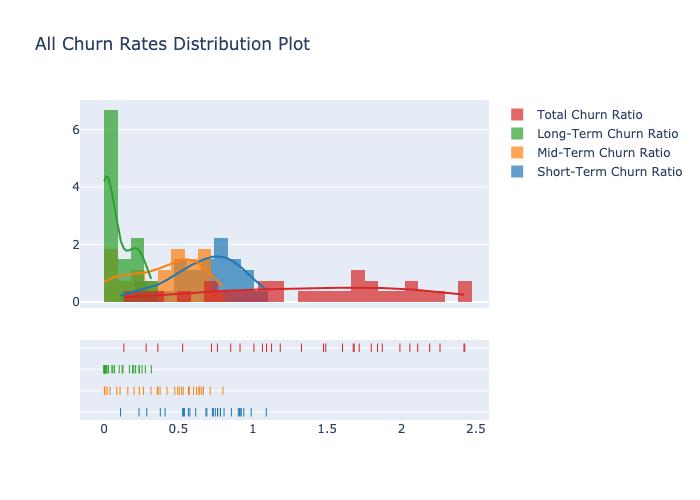

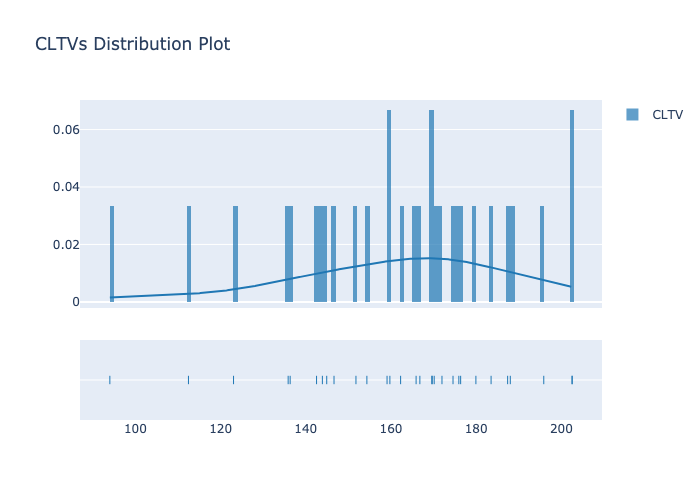

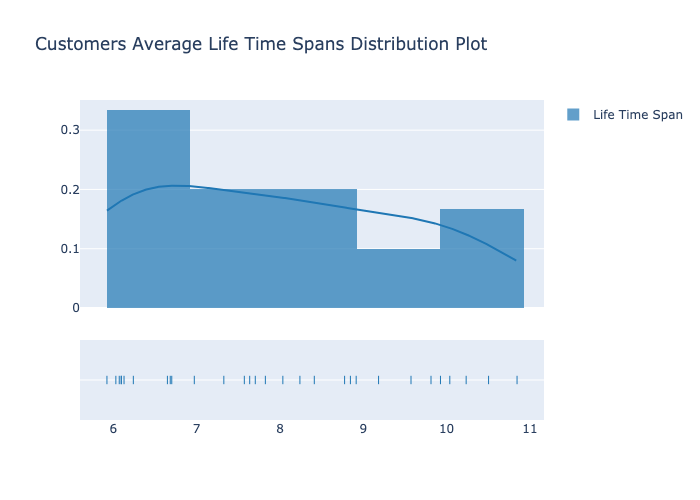

In [82]:
x01 = all_churnrates['Short-Term Churn Ratio(%)']
x02 = all_churnrates['Mid-Term Churn Ratio(%)']
x03 = all_churnrates['Long-Term Churn Ratio(%)']
x04 = all_churnrates['Total Churn Ratio(%)']

hist_data = [x01, x02, x03, x04]

group_labels = ['Short-Term Churn Ratio', 'Mid-Term Churn Ratio', 'Long-Term Churn Ratio', 'Total Churn Ratio']
fig = ff.create_distplot(hist_data, group_labels, bin_size=.09)
fig.update_layout(title_text="All Churn Rates Distribution Plot")
fig.show("png")

x05 = CLTV.CLTV
x06 = LifeTimeSpans['Life Time Span']

hist_data1 = [x05]
hist_data2 = [x06]
group_labels1 = ['CLTV']
group_labels2 = ['Life Time Span']
fig1 = ff.create_distplot(hist_data1, group_labels1)
fig2 = ff.create_distplot(hist_data2, group_labels2)
fig1.update_layout(title_text="CLTVs Distribution Plot")
fig2.update_layout(title_text="Customers Average Life Time Spans Distribution Plot")
fig1.show("png")
fig2.show("png")

None of our data has a normal distribution. This information is so important for our future analysis.

# Correlation Analysis

In the Correlation Matrix, each box takes a value between -1 and +1. If this value is close to -1, we say that there is a strong negative relationship between these two variables, and if it is close to +1, we say that there is a strong positive relationship between them. If it is close to zero, we can say that there is no relationship between these two variables. The range that we will assume there is no relationship is -0.2 < cc < 0.2. (cc: correlation coefficent)

None of our data has a normal distribution. So we can use Spearmann's correlation coefficient to measure the meaning of the relationship between them. It should be noted that Pearon's correlation coefficient is valid only for data with normal distribution.

In [83]:
corr = All_Data.corr(method = 'spearman')
corr

,Short-Term Churn Ratio,Mid-Term Churn Ratio,Long-Term Churn Ratio,Total Churn Ratio,CLTV,Life Time Span
Short-Term Churn Ratio,1.000000,0.767297,0.698776,0.880756,0.591991,0.695662
Mid-Term Churn Ratio,0.767297,1.000000,0.967075,0.969299,0.782870,0.963070
Long-Term Churn Ratio,0.698776,0.967075,1.000000,0.931034,0.752614,0.975528
Total Churn Ratio,0.880756,0.969299,0.931034,1.000000,0.733482,0.927030
CLTV,0.591991,0.782870,0.752614,0.733482,1.000000,0.768632
Life Time Span,0.695662,0.963070,0.975528,0.927030,0.768632,1.000000


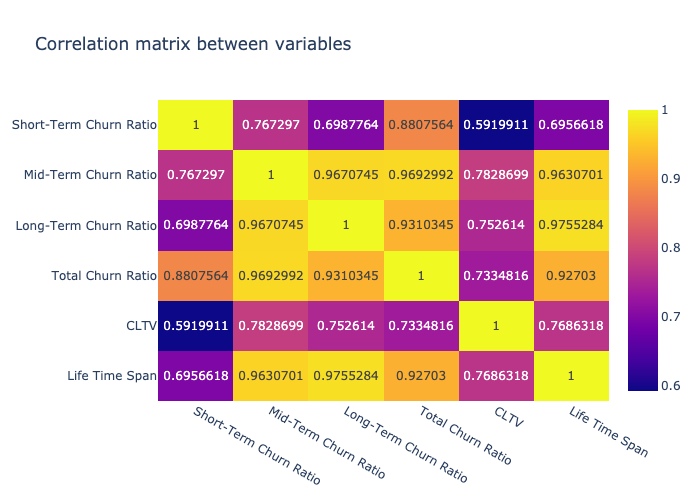

In [84]:
fig = px.imshow(corr, text_auto=True, aspect="auto", title="Correlation matrix between variables")
fig.show("png")

# Simple Linear Regression Modelling and test of the Model's Significance

Correlation can only tell us whether there is a relationship between these two variables and its strength. But is it regression? Of course not, the regression can tell us the effect of Life Time Span on CLTV. However, regression can only estimate and give us an approximation.

We will so regression analysis between two varible, so we will use Simple Linear Regression model. Independent variable (X) is Customers Average Life Time Spans and the Dependent variable (Y) is CLTV. In this way we can observe the effect of X on Y.

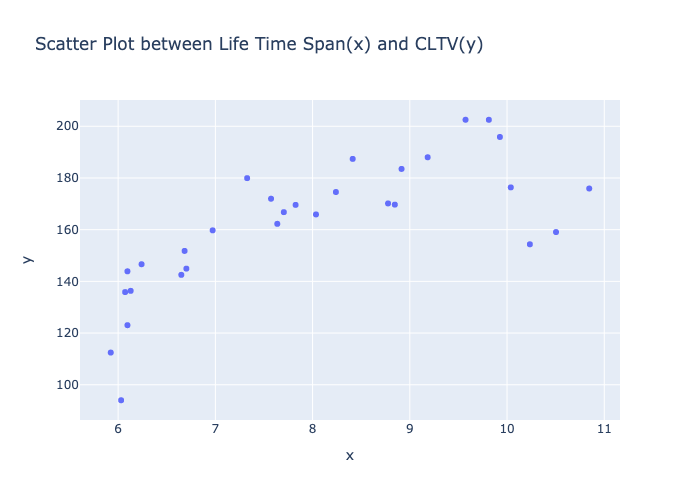

In [85]:
fig = px.scatter(x=All_Data['Life Time Span'], y=All_Data['CLTV'], title="Scatter Plot between Life Time Span(x) and CLTV(y)")
fig.show("png")

In [86]:
x001 = All_Data['Life Time Span']
y001 = All_Data['CLTV']
x001 = sm.add_constant(x001)
model = sm.OLS(y001,x001).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   CLTV   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     32.74
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           3.88e-06
Time:                        16:40:11   Log-Likelihood:                -127.52
No. Observations:                  30   AIC:                             259.0
Df Residuals:                      28   BIC:                             261.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             65.6202     17.076      3.

## There are 2 important points for us in this table, and when we interpret the values at these 2 points, our analysis will be fully understood.

Coefficients : The regression coefficient is a statistical measure of the average functional relationship between two or more variables. In Table, where it is written for const, it gives the value of the constant in the regression formula, and where it is written for Life Time Span, it shows how much the CLTV will change with one unit change in Life Time Span. Therefore, the regression model makes use of the coefficients here when making predictions.

P-Value: This value gives us whether the coefficient obtained from the independent variable is statistically significant. The significance value generally accepted in the scientific world is p < 0.05. If the result is above this value, the effect of the relevant independent variable on the model is not significant. This value is used during the selection of variables in multivariate regression analysis. In our table, this value is < 0.05 and therefore the regression model we created is also significant.

## Now that we have examined our table, let's draw the regression line formed as a result of the model on the scatter plot above.

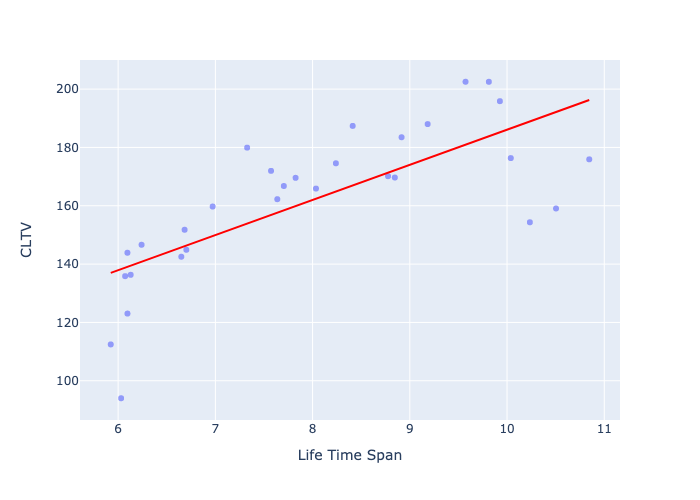

In [87]:
fig = px.scatter(
    All_Data, x='Life Time Span', y='CLTV', opacity=0.65,
    trendline='ols', trendline_color_override='red')
fig.show("png")

As can be seen in this graph, the regression line is drawn with the least error between the points.